# DiaBETO: a Diabetes intelligent assistant - Better Early Treatment Oracle

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

# Part 1: Load data into Colab

In [12]:
# Requiered to select a file from your HD
from google.colab import files
uploaded = files.upload()

Saving Diabetes2.csv to Diabetes2 (1).csv


In [18]:
# Import file and store it in a data frame
df = pd.read_csv('Diabetes2.csv') # Cambia al nombre del archivo que cargues
df.dropna(inplace=True)
df.drop(columns=['Unnamed: 0'], inplace=True)
df.CLASS = np.where(df.CLASS=='N', 0, 1)
df

,edad,genero,glucosa,IMC,CLASS
0,50,Femenino,4.9,24.0,0
1,26,Masculino,4.9,23.0,0
2,50,Femenino,4.9,24.0,0
3,50,Femenino,4.9,24.0,0
4,33,Masculino,4.9,21.0,0
...,...,...,...,...,...
995,71,Masculino,7.0,30.0,1
996,31,Masculino,12.3,37.2,1
997,30,Masculino,6.7,27.4,1
998,38,Masculino,6.7,40.5,1


# Part 2: Format data and split it into numpy arrays

In [19]:
def gender_to_categorical(gen):
  enc = OneHotEncoder(sparse=False)
  WD = enc.fit_transform(gen)
  print("== categories:", enc.categories_, "==")
  return WD, [item for sublist in enc.categories_ for item in sublist]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


== categories: [array(['Femenino', 'Masculino'], dtype=object)] ==
Input values X with shape (1000, 5). With values


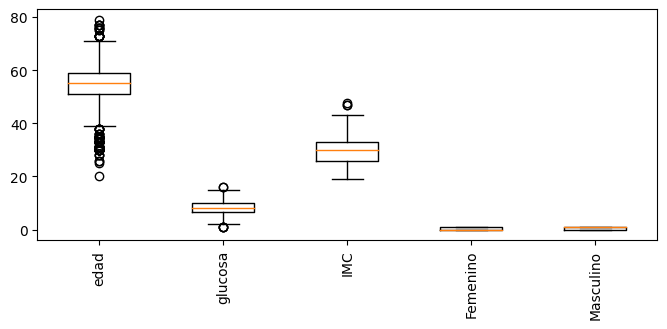

,0,1,2,3,4
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,53.528000,8.281160,29.578020,0.435000,0.565000
std,8.799241,2.534003,4.962388,0.496005,0.496005
min,20.000000,0.900000,19.000000,0.000000,0.000000
25%,51.000000,6.500000,26.000000,0.000000,0.000000
50%,55.000000,8.000000,30.000000,0.000000,1.000000
75%,59.000000,10.200000,33.000000,1.000000,1.000000
max,79.000000,16.000000,47.750000,1.000000,1.000000


In [20]:
# Extract input features and convert them to a numpy array
labels = ['edad', 'glucosa', 'IMC' ]
X = df[labels].to_numpy()
WD, categories = gender_to_categorical(df[['genero']])
X = np.concatenate((X, WD), axis=1)

print(f"Input values X with shape {X.shape}. With values")

plt.figure(figsize=(8, 3))
plt.boxplot(X)
plt.xticks(range(1, 6), labels + categories, rotation=90)
plt.show()

pd.DataFrame(X).describe()

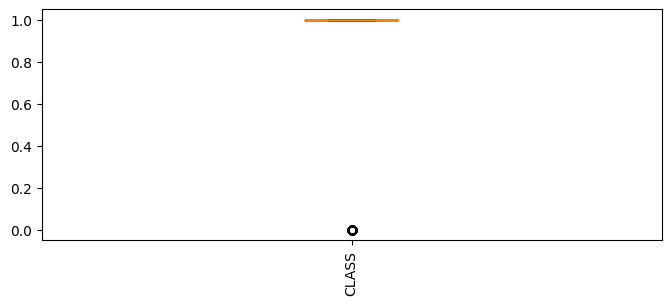

,0
count,1000.0000
mean,0.8980
std,0.3028
min,0.0000
25%,1.0000
50%,1.0000
75%,1.0000
max,1.0000


In [21]:
# Extract output features and convert them to a numpy array
Y = df[['CLASS']].to_numpy()

plt.figure(figsize=(8, 3))
plt.boxplot(Y)
plt.xticks(range(1, 2), ['CLASS'], rotation=90)
plt.show()

pd.DataFrame(Y).describe()

In [22]:
# Split data into train+val and test sets
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(900, 5)
(900, 1)
(100, 5)
(100, 1)


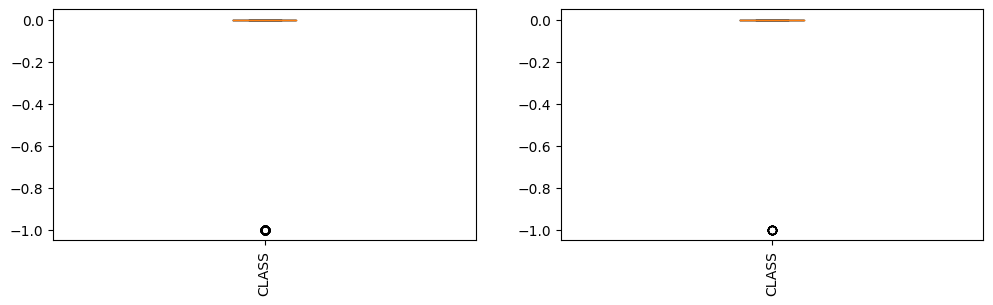

,0
count,900.000000
mean,-0.102222
std,0.303109
min,-1.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,0.000000


In [23]:
# Normalize (zero-center) and standardize (scale) output data
scalerY = RobustScaler()
y_train = scalerY.fit_transform(y_train)
y_test = scalerY.transform(y_test)

plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
plt.boxplot(y_train)
plt.xticks(range(1, 2), ['CLASS'], rotation=90)
plt.subplot(1, 2, 2)
plt.boxplot(y_test)
plt.xticks(range(1, 2), ['CLASS'], rotation=90)
plt.show()

pd.DataFrame(y_train).describe()

# Part 3: Create DNN models and train them

In [25]:
!pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 15.2 MB/s eta 0:00:00


In [26]:
# tensorflow imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense
from tensorflow.keras.optimizers import Adam

import keras_tuner as kt
from keras_tuner.tuners import RandomSearch

# Part 3.1: DNN with custom functions

In [ ]:
mlp = Sequential([
                  InputLayer(30),
                  Dense(512, activation='relu'),
                  Dense(128, activation='relu'),
                  Dense( 32, activation='relu'),
                  Dense(6, activation='softmax')
])

mlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               15872     
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 dense_3 (Dense)             (None, 6)                 198       
                                                                 
Total params: 85,862
Trainable params: 85,862
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Create a Deep Network
DNN = Sequential()
DNN.add(InputLayer(input_shape=x_train.shape[1:], name='INPUT'))

DNN.add(Dense(units=1024, activation='relu'))
DNN.add(Dense(units=512, activation='relu'))
DNN.add(Dense(units=256, activation='relu'))

DNN.add(Dense(units=y_train.shape[1], activation='linear', name='OUTPUT'))

DNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              29696     
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 OUTPUT (Dense)              (None, 2)                 514       
                                                                 
Total params: 686,338
Trainable params: 686,338
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def r_square(y, y_hat):
  """ Define R square loss, to use it as metric during training
  """
  residual = tf.reduce_sum(tf.square(tf.subtract(y, y_hat)))
  total = tf.reduce_sum(tf.square(tf.subtract(y, tf.reduce_mean(y))))
  return tf.subtract(1.0, residual / total)

In [ ]:
def my_mse(y, y_hat):
  """ Define MSE loss, to use it as loss function
  """
  return tf.reduce_mean(tf.square(y - y_hat))

In [ ]:
# Define training parameters
# Option 1: Usar un optimizador predefinido, pero con hyperparams no estándar
#from tensorflow.keras.optimizers import SGD
#sgd = SGD(learning_rate=0.02, momentum=0.6)
#DNN.compile(optimizer=sgd, loss='mse')

# Option 2: Usar optimizador predefinido, con una pérdida custom, e incluir otras
# métricas de monitoreo
DNN.compile(optimizer='adam', loss=my_mse, metrics=['mape', r_square])

# Try with different optimizers
#DNN.compile(optimizer=???, loss='mse')

In [ ]:
# Train model
H = DNN.fit(x=x_train, y=y_train, batch_size=128, epochs=30, validation_split=0.1)

Epoch 1/30
202/202 [==============================] - 4s 8ms/step - loss: 726.6567 - mape: 16959480.0000 - r_square: -879.2759 - val_loss: 0.4104 - val_mape: 1727380.7500 - val_r_square: 0.3734
Epoch 2/30
202/202 [==============================] - 1s 6ms/step - loss: 25.8820 - mape: 10498903.0000 - r_square: -36.5811 - val_loss: 1.0489 - val_mape: 3675646.2500 - val_r_square: -0.6052
Epoch 3/30
202/202 [==============================] - 1s 6ms/step - loss: 0.4263 - mape: 1743144.6250 - r_square: 0.3796 - val_loss: 0.4491 - val_mape: 1773724.6250 - val_r_square: 0.3193
Epoch 4/30
202/202 [==============================] - 1s 6ms/step - loss: 0.3197 - mape: 1394894.8750 - r_square: 0.5352 - val_loss: 0.6555 - val_mape: 2179828.5000 - val_r_square: 0.0065
Epoch 5/30
202/202 [==============================] - 1s 6ms/step - loss: 0.3754 - mape: 1593221.0000 - r_square: 0.4552 - val_loss: 0.2163 - val_mape: 1455561.3750 - val_r_square: 0.6699
Epoch 6/30
202/202 [=============================

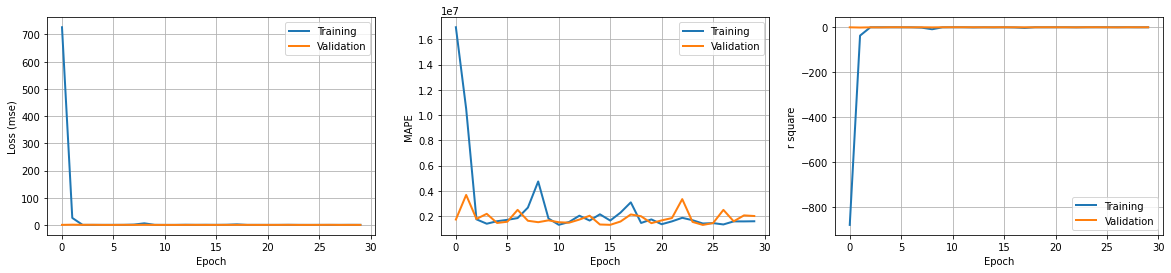

In [ ]:
# Plot loss
plt.figure(figsize=(20, 4))
plt.subplot(1, 3, 1)
plt.plot(DNN.history.history['loss'], label='Training', linewidth=2)
plt.plot(DNN.history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss (mse)')
plt.grid()
plt.subplot(1, 3, 2)
plt.plot(DNN.history.history['mape'], label='Training', linewidth=2)
plt.plot(DNN.history.history['val_mape'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MAPE')
plt.grid()
plt.subplot(1, 3, 3)
plt.plot(DNN.history.history['r_square'], label='Training', linewidth=2)
plt.plot(DNN.history.history['val_r_square'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('r square')
plt.grid()
plt.show()

In [ ]:
# Compute test loss
loss_test = DNN.evaluate(x=x_test, y=y_test, verbose=False)
print("Test loss, MAPE, and r2:", loss_test)

Test loss, MAPE, and r2: [0.32468682527542114, 1231897.125, 0.5469706058502197]


In [ ]:
# Predict on test set
y_test_hat = DNN.predict(x=x_test)
print(y_test_hat.shape)

100/100 [==============================] - 0s 2ms/step
(3182, 2)


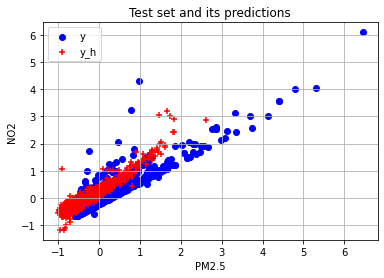

In [ ]:
# Plot y_test_hat
indx = np.random.permutation(len(y_test))[:500]
plt.scatter(y_test[indx, 0], y_test[indx, 1], c='b', label='y')
plt.scatter(y_test_hat[indx, 0], y_test_hat[indx, 1], c='r', marker='+', label='y_h')

plt.legend()
plt.grid(True)
plt.xlabel('PM2.5')
plt.ylabel('NO2')
plt.title('Test set and its predictions')
plt.show()

# 3.2 Auto tuning of hyperparams: number of units and optimizer

In [27]:
def model_builder(hp):
  ''' Define a auxiliar function to create DNN models with varying
      hyperparameters.
  '''
  model = Sequential()
  model.add(InputLayer(input_shape=x_train.shape[1:], name='INPUT'))

  # Choose an optimal number of units for the unique hidden layer between 64-1024
  hp_units = hp.Int('units', min_value=64, max_value=1024, step=64)
  model.add(Dense(units=hp_units, activation='relu'))
  # Add output layer
  model.add(Dense(units=y_train.shape[1], name='OUTPUT', activation='sigmoid'))

  # Choose best optimizer
  model.compile(optimizer=hp.Choice('optimizer', values=['sgd', 'adam', 'adagrad', 'adadelta']), loss='mse', metrics=['mape'])
  
  return model

In [28]:
# Create a tuner and show the search space
tuner = RandomSearch(model_builder,
                     objective='val_loss',
                     max_trials=32)

tuner.search_space_summary()

Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 1024, 'step': 64, 'sampling': 'linear'}
optimizer (Choice)
{'default': 'sgd', 'conditions': [], 'values': ['sgd', 'adam', 'adagrad', 'adadelta'], 'ordered': False}


In [29]:
# Make an initial quick exploration of the hyperparam space
tuner.search(x_train, y_train, epochs=10, validation_split=0.1)

Trial 17 Complete [00h 00m 03s]
val_loss: 0.08888889104127884

Best val_loss So Far: 0.08888889104127884
Total elapsed time: 00h 01m 02s

Search: Running Trial #18

Value             |Best Value So Far |Hyperparameter
896               |192               |units
adadelta          |sgd               |optimizer



KeyboardInterrupt: ignored

In [ ]:
# Get the top model
best_models = tuner.get_best_models()
best_model = best_models[0]
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 960)               27840     
                                                                 
 OUTPUT (Dense)              (None, 2)                 1922      
                                                                 
Total params: 29,762
Trainable params: 29,762
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# See top best results
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
units: 960
optimizer: adagrad
Score: 0.2404097467660904
Trial summary
Hyperparameters:
units: 896
optimizer: adam
Score: 0.2759658694267273
Trial summary
Hyperparameters:
units: 576
optimizer: adagrad
Score: 0.28821346163749695
Trial summary
Hyperparameters:
units: 704
optimizer: adam
Score: 0.3020375967025757
Trial summary
Hyperparameters:
units: 704
optimizer: adagrad
Score: 0.3062101900577545
Trial summary
Hyperparameters:
units: 960
optimizer: adam
Score: 0.32970574498176575
Trial summary
Hyperparameters:
units: 320
optimizer: adam
Score: 0.34830552339553833
Trial summary
Hyperparameters:
units: 768
optimizer: adam
Score: 0.3536406457424164
Trial summary
Hyperparameters:
units: 512
optimizer: adagrad
Score: 0.37855640053749084
Trial summary
Hyperparameters:
units: 256
optimizer: adam
Score: 0.3847929537296295


In [ ]:
# Retrieve the best combination of hyperparams
best_hps = tuner.get_best_hyperparameters()[0]
best_hps.values

{'units': 960, 'optimizer': 'adagrad'}

In [ ]:
# Create a new model using the best hyperparams
DNN = model_builder(best_hps)
DNN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 960)               27840     
                                                                 
 OUTPUT (Dense)              (None, 2)                 1922      
                                                                 
Total params: 29,762
Trainable params: 29,762
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Full training of best model
H = DNN.fit(x=x_train, y=y_train, batch_size=64, epochs=100, validation_split=0.1)

Epoch 1/100
403/403 [==============================] - 1s 3ms/step - loss: 61.4688 - mape: 6553068.5000 - val_loss: 1.0121 - val_mape: 2839496.2500
Epoch 2/100
403/403 [==============================] - 1s 3ms/step - loss: 0.7322 - mape: 2480596.0000 - val_loss: 0.5233 - val_mape: 2203265.0000
Epoch 3/100
403/403 [==============================] - 1s 3ms/step - loss: 0.4866 - mape: 2045649.0000 - val_loss: 0.3972 - val_mape: 2017180.1250
Epoch 4/100
403/403 [==============================] - 1s 3ms/step - loss: 0.3974 - mape: 1888965.7500 - val_loss: 0.4273 - val_mape: 2332913.0000
Epoch 5/100
403/403 [==============================] - 1s 3ms/step - loss: 0.3568 - mape: 1721967.5000 - val_loss: 0.3269 - val_mape: 1857132.0000
Epoch 6/100
403/403 [==============================] - 1s 3ms/step - loss: 0.3275 - mape: 1655991.7500 - val_loss: 0.3189 - val_mape: 1876019.2500
Epoch 7/100
403/403 [==============================] - 1s 3ms/step - loss: 0.3116 - mape: 1615003.2500 - val_loss: 0.

# 3.2 Auto tuning of hyperparams: number of layers, number of units, and optimizer

In [62]:
def model_builder(hp):
  ''' Define a auxiliar function to create DNN models with varying
      hyperparameters.
  '''
  model = Sequential()
  model.add(InputLayer(input_shape=x_train.shape[1:], name='INPUT'))

  # Choose optimal number of layers between 2 and 8
  for i in range(hp.Int('num_layers', 2, 8)):
    # Tune the number of units in the each dense layer
    hp_units = hp.Int('units_'+str(i), min_value=64, max_value=1024, step=64)
    model.add(Dense(units=hp_units, activation='tanh'))
  # Add output layer
  model.add(Dense(units=y_train.shape[1], name='OUTPUT', activation='sigmoid'))

  # Choose best optimizer
  model.compile(optimizer=hp.Choice('optimizer', values=['sgd', 'adam', 'adagrad', 'adadelta']), loss=tf.keras.losses.BinaryCrossentropy(), 
                metrics=['accuracy', tf.keras.metrics.Recall(),
     tf.keras.metrics.Precision()])
  
  return model

In [63]:
# Create a tuner and show the search space
tuner = RandomSearch(model_builder,
                     objective='val_loss',
                     max_trials=64)

tuner.search_space_summary()

Search space summary
Default search space size: 11
units (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 1024, 'step': 64, 'sampling': 'linear'}
optimizer (Choice)
{'default': 'sgd', 'conditions': [], 'values': ['sgd', 'adam', 'adagrad', 'adadelta'], 'ordered': False}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 8, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 1024, 'step': 64, 'sampling': 'linear'}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 1024, 'step': 64, 'sampling': 'linear'}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 1024, 'step': 64, 'sampling': 'linear'}
units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 1024, 'step': 64, 'sampling': 'linear'}
units_4 (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 1024, 'step': 64, 'sampling':

In [64]:
# Make an initial quick exploration of the hyperparam space
tuner.search(x_train, y_train, epochs=10, validation_split=0.1)

In [65]:
# Get the top model
tuner.get_best_models()[0].summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              6144      
                                                                 
 dense_1 (Dense)             (None, 832)               852800    
                                                                 
 dense_2 (Dense)             (None, 896)               746368    
                                                                 
 dense_3 (Dense)             (None, 384)               344448    
                                                                 
 dense_4 (Dense)             (None, 320)               123200    
                                                                 
 dense_5 (Dense)             (None, 960)               308160    
                                                                 
 dense_6 (Dense)             (None, 384)               3

In [66]:
# Create a new model using the best hyperparams
DNN = model_builder(tuner.get_best_hyperparameters()[0])
DNN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 1024)              6144      
                                                                 
 dense_8 (Dense)             (None, 832)               852800    
                                                                 
 dense_9 (Dense)             (None, 896)               746368    
                                                                 
 dense_10 (Dense)            (None, 384)               344448    
                                                                 
 dense_11 (Dense)            (None, 320)               123200    
                                                                 
 dense_12 (Dense)            (None, 960)               308160    
                                                                 
 dense_13 (Dense)            (None, 384)              

In [67]:
# Full training of best model
H = DNN.fit(x=x_train, y=y_train, batch_size=64, epochs=100, validation_split=0.1)

Epoch 1/100
13/13 [==============================] - 4s 33ms/step - loss: -2.0631 - accuracy: 0.8963 - recall_1: 0.0000e+00 - precision_1: 0.0000e+00 - val_loss: -2.4937 - val_accuracy: 0.9111 - val_recall_1: 0.0000e+00 - val_precision_1: 0.0000e+00
Epoch 2/100
13/13 [==============================] - 0s 8ms/step - loss: -3.1403 - accuracy: 0.8963 - recall_1: 0.0000e+00 - precision_1: 0.0000e+00 - val_loss: -2.8971 - val_accuracy: 0.9111 - val_recall_1: 0.0000e+00 - val_precision_1: 0.0000e+00
Epoch 3/100
13/13 [==============================] - 0s 9ms/step - loss: -3.5890 - accuracy: 0.8963 - recall_1: 0.0000e+00 - precision_1: 0.0000e+00 - val_loss: -3.3383 - val_accuracy: 0.9111 - val_recall_1: 0.0000e+00 - val_precision_1: 0.0000e+00
Epoch 4/100
13/13 [==============================] - 0s 9ms/step - loss: -4.1062 - accuracy: 0.8963 - recall_1: 0.0000e+00 - precision_1: 0.0000e+00 - val_loss: -3.7432 - val_accuracy: 0.9111 - val_recall_1: 0.0000e+00 - val_precision_1: 0.0000e+00
Epo

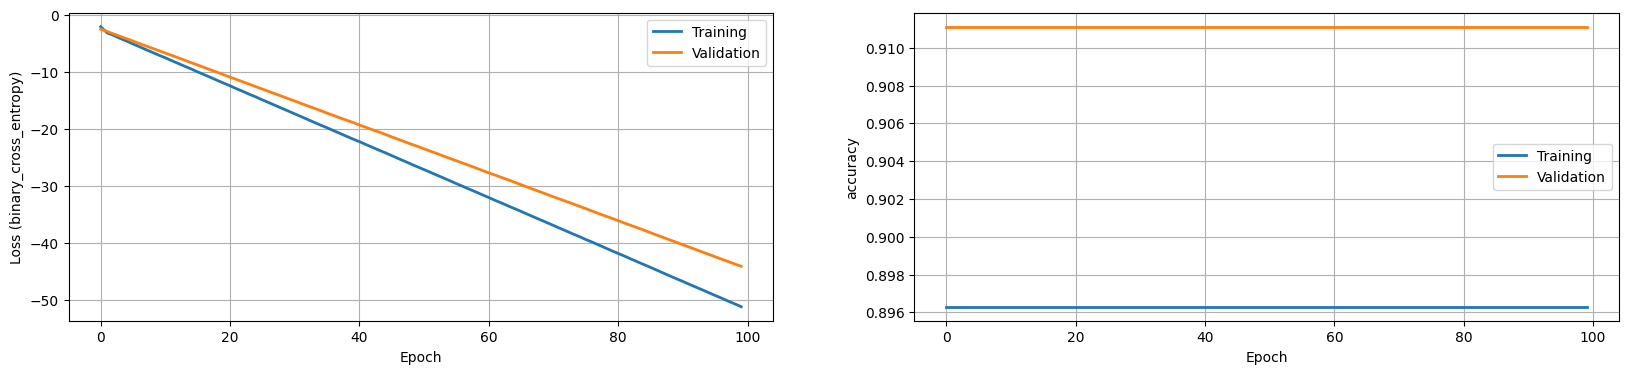

In [68]:
# Plot loss
plt.figure(figsize=(20, 4))
plt.subplot(1, 2, 1)
plt.plot(DNN.history.history['loss'], label='Training', linewidth=2)
plt.plot(DNN.history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss (binary_cross_entropy)')
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(DNN.history.history['accuracy'], label='Training', linewidth=2)
plt.plot(DNN.history.history['val_accuracy'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.grid()
plt.show()

In [69]:
# Compute test loss
loss_test = DNN.evaluate(x=x_test, y=y_test, verbose=False)
print("Test loss and accuracy:", loss_test)

Test loss and accuracy: [-49.5323486328125, 0.8999999761581421, 0.0, 0.0]


In [74]:
# Predict on test set
y_test_hat = DNN.predict(x=x_test)
error = np.mean( y_test != y_test_hat )
print(error)

4/4 [==============================] - 0s 3ms/step
0.1


# Part 4: save model to disk and load it back





In [75]:
# Save model to disk, then delete it

DNN.save("DiaBETO.h5")

del DNN

In [76]:
# Load model back into memory, and use it for prediction
from tensorflow.keras.models import load_model
DNN = load_model("DiaBETO.h5")

y_test_hat = DNN.predict(x=x_test)
print(y_test_hat.shape)

4/4 [==============================] - 0s 4ms/step
(100, 1)
